<a href="https://colab.research.google.com/github/hansong0219/Advanced-DeepLearning-Study/blob/master/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MNIST Datasets 을 활용한 오토인코더
------------

오토인코더는 주어진 입력 데이터의 압축 표현을 찾기 위한 심층 신경망 구조이다.
오토인코더는 사람이 레이블을 직접 달지 않아도 데이터만 가지고 코드를 자동으로 학습하기 때문에 비지도 학습 알고리즘으로 분류된다. 

오토인코더의 역할은 입력 분포를 벡터형태를 띠는 저차원의 텐서로 인코딩하고 잠재 표현이나, 코드로 불리는 숨겨진 구조로 근사화 한다. 그런다음 이러한 잠재벡터를 원본 입력을 복원하기 위해 디코더를 통해 디코딩 한다.
이런 이유에서 입력 데이터와 출력 데이터의 차이를 손실함수로 근사화한다. 

아래는 MNIST 데이터의 오토인코더의 예시이다.

In [ ]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

데이터 전처리
-----

MNIST 데이터 세트 로딩

In [ ]:
# 라벨을 사용하지 않기 때문에, Label 데이터를 출력할 필요가 없다.
(x_train, _),(x_test, _) = mnist.load_data()

Image format 을 (28, 28, 1) 로 조정하고 입력 이미지를 정규화한다.

In [ ]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
# 네트워크 매개 변수 지정 
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3

#16 차원 잠재 벡터로 변경
latent_dim = 16

#CNN 계층당 필터의 인코더/디코더 개수
layer_filters = [32, 64]

# 모델 구성

In [ ]:
# 인코더 구성 
inputs =Input(shape=input_shape, name = 'encoder_input')

x = inputs

# Conv2D 스택
for filters in layer_filters:
  x = Conv2D(filters = filters, 
             kernel_size = kernel_size,
             activation = 'relu',
             strides = 2,
             padding = 'same')(x)

인코더 모델의 구성을 완료하기 전에 디코더의 입력에 대해 정보를 확인한다.  7, 7, 64 로 주어짐을 다음과 같이 확인할 수 있다.

In [ ]:
# 디코더 input 정보 
shape = K.int_shape(x)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


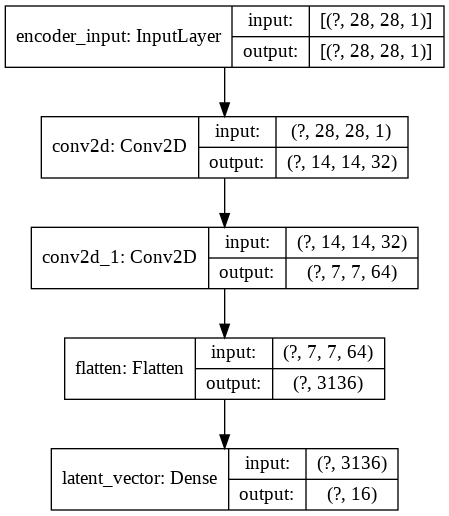

In [ ]:
# 잠재 벡터의 생성 
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)

#인코더 모델 인스턴스화
encoder = Model(inputs, latent, name = 'encoder')
encoder.summary()
plot_model(encoder, show_shapes = True)

In [ ]:
# 디코더 구성 
latent_inputs = Input(shape=(latent_dim,), name = 'decoder_input')

x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
# 벡터에서 전치 합성곱에 사용할 적절한 형상으로 변환한다.
x = Reshape((shape[1],shape[2],shape[3]))(x)

#Conv2DTranspose(64) - Conv2Dtranspose(32) 로 스택
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters = filters,
                      kernel_size = kernel_size,
                      activation='relu',
                      strides = 2,
                      padding='same')(x)

#Sigmoid 를 통한 입력의 재구성
outputs = Conv2DTranspose(filters = 1,
                          kernel_size= kernel_size,
                          activation = 'sigmoid',
                          padding = 'same', 
                          name = 'decoder_output')(x)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

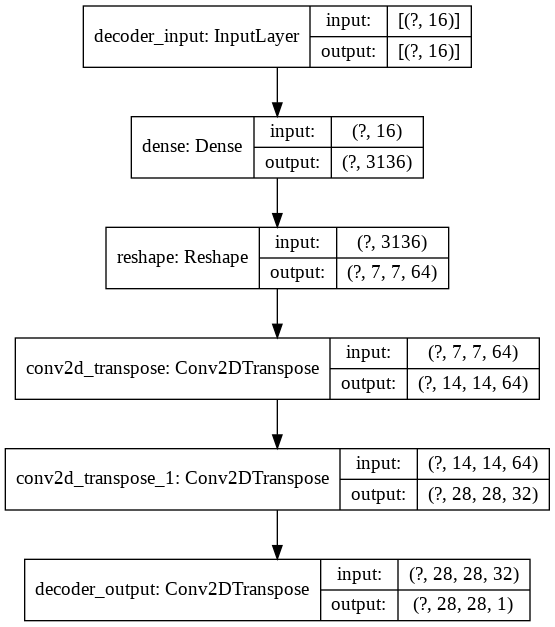

In [ ]:
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()
plot_model(decoder, show_shapes=True)

In [ ]:
#autoencoder = encoder + decoder
autoencoder = Model(inputs,decoder(encoder(inputs)), name = "autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


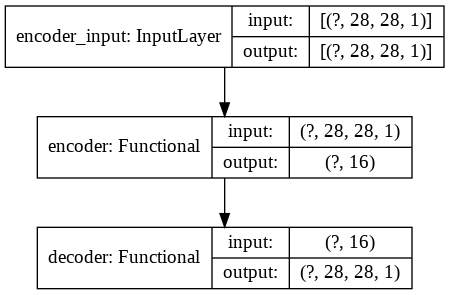

In [ ]:
plot_model(autoencoder, show_shapes = True)

In [ ]:
#모델 컴파일
autoencoder.compile(loss='mse', optimizer='adam') 

In [ ]:
#오토 인코더의 훈련
autoencoder.fit(x_train, x_train, validation_data = (x_test, x_test), epochs=1, batch_size = batch_size)

1875/1875 [==============================] - 108s 57ms/step - loss: 0.0218 - val_loss: 0.0106


출력 예측
-----

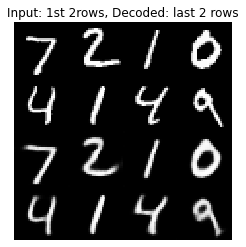

In [ ]:
#테스트 데이터에서 오토 인코더 출력 예측 
x_decoded = autoencoder.predict(x_test)

imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Input: 1st 2rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()